Zihao Mao

Cameron Matson

9/22/2017

# Lab 7: CNN

## Introduction

For this lab we examine the images of the Stanford Dog Dataset.  The dataset consits of ~20,000 images of dogs from 120 different breeds.

#### Issues
The dataset is primarily used for fine-grained classification problems, meaning that the instances are all members of the same main class and are divided by subclass.  In this case, the main class is 'Dog' and the subclass is the breed: 'Beagle', 'Poodle', 'Lab'...  These are potentially more difficult than standard classification problems because in theory all members of teh main class should at least share similar features.  In other words as the saying goes "a dog is a dog is a dog not a cat."

Another challenge with this dataset is that there is that they do not depict a standard scene.  These are not faces of dogs.  These are not photoshoot photos of dogs.  The images in the dataset are not even exclusively of dogs.  Some contain multiple dogs or even people.  The dataset would benefit from preprocessing in the form of some sort of standardization such that all the images are of the same kind, using facial detection for instance.

#### Uses


#### Accuracy
How well does a system like that need to work?  Well each successive level probably does not need to be as precise as the last (and it likely won't be cause each successive level is more difficult than the last.)  The key point is that a human (with some knowledge of dog breeds) would be close to perfect at identifying dogs, but with thousands of street cameras around, it would take them a long time to go through all the footage.  Assuming you do a good job of identifying the dogs in the image you probably don't have to be that accurate at identifing the bichon frise.  As long as you have as few false negatives as possible (so that you don't miss a potential bichon) you could probably get away with a few false positives.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.misc import imresize
from skimage.color import rgb2gray
%matplotlib inline
imagedir = '../img_data/dogs/Images'

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import average 
from keras.models import Input, Model
from keras.regularizers import l2
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn import metrics as mt
NUM_CLASSES = 5
keras.__version__

Using TensorFlow backend.


'2.0.9'

## Data Preprocessing

There are 120 different breeds included in the dataset with bout 150 images of each breed for a total of 20,580 images.  The images are stored in directories by breed.  To make the size of the dataset more managable, we'll take a sample of 50 images from each 60 of the breed.

In [3]:
# remove dsstore
for d in os.listdir(imagedir):
    if d.find('.DS') != -1:
        os.remove(os.path.join(imagedir,d))
        continue
    for f in os.listdir(os.path.join(imagedir, d)):
        if f.find('.DS') != -1:
            os.remove(os.path.join(imagedir,d,f))
    

In [4]:
def load_images(num_classes, h, w):
    
    # preinitialize the matrix
    #img_arr = np.empty((num_samples_per_breed*num_breeds,h*w))  # 20 instances of each breed, each img will be 200x200 = 40000 pixels
    img_arr = []
    label_arr = []
    
    # sample 60 breeds from the dataset
    a = np.arange(len(os.listdir(imagedir)))
    np.random.shuffle(a)
    breed_sample_idxs = a[:num_classes]
    for i, idx in enumerate(breed_sample_idxs):
        breed = os.listdir(imagedir)[idx]
        if breed[0] == '.' : 
            continue # stupid ds.store on mac
        print(i,breed)
        
        for img in os.listdir(os.path.join(imagedir, breed)):
            dog_path = os.path.join(imagedir,breed,img)            

            img = plt.imread(dog_path)
            
            # converts image to gray, resizes it to be 200x200, and then linearizes it
            img_gray_resize_flat = rgb2gray(imresize(img, (h,w,3))).flatten()
                        
            img_arr.append(img_gray_resize_flat)

            # add name to list of labels
            fname = dog_path.split('/')[-1] # 'dog_name_123497.jpg'
            dog_name = fname[:fname.rfind('_')] # 'dog_name'
            label_arr.append(breed)
            
    return img_arr, label_arr

In [5]:
%%time
num_breeds = 5
h=128
w=128
dogs, labels = load_images(num_classes=num_breeds, h=h, w=w)
print(len(dogs))

0 Doberman
1 Chesapeake_Bay_retriever
2 toy_poodle
3 curly
4 Yorkshire_terrier
783
Wall time: 5.88 s


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df= pd.DataFrame(dogs)

X = np.array(dogs)

enc = LabelEncoder()
y = enc.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [7]:
img_hw = 128
img_wh = 128
l2_lambda = 0.0001

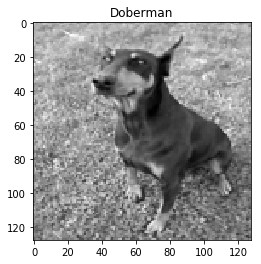

In [8]:
ex = dogs[0].reshape((h,w))
plt.imshow(ex, cmap='gray')
plt.title(labels[0])
plt.show()

### Cross Validation Scheme

Since these networks take SOO long to train and we don't have that much data, we're  going to use a 3-fold cross-validation set up.  K-fold because we can't afford to not train on all of thee data, and 3 folds so we can finish on time.  We'll also use stratified folds to be safe even though our breed distribution is pretty uniform.  After we train the 3 models we'll be able to look at the average performance to get a sense of how the model might perform once deployed.

## MLP

In [25]:
def do_mlp(X_train, y_train, X_test, y_test):
    # make a 3 layer keras MLP
    mlp = Sequential()
    mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add( Dense(units=30, activation='relu') )
    mlp.add( Dense(NUM_CLASSES) )
    mlp.add( Activation('softmax') )

    mlp.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    mlp.fit(X_train, y_train, 
            batch_size=32, epochs=10, 
            shuffle=True, verbose=1)
    
    yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
    
    return mt.accuracy_score(y_test,yhat_mlp)

## cnn1: simple

In [39]:
%%time
def do_cnn1(X_train, y_train, X_test, y_test, y_test_ohe):
    cnn_layers = [32, 16]

    # make a CNN with conv layer and max pooling
    cnn = Sequential()
    cnn.add(Reshape((1, 128, 128), input_shape=(1,128*128)))

    for n in cnn_layers:
        cnn.add(Conv2D(filters=n, kernel_size= (3, 3), padding='same', input_shape=(1, h,w), data_format='channels_first'))
        cnn.add(Activation('relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    # add one layer on flattened output
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())

    cnn.add(Dropout(0.25))
    cnn.add(Dense(80))
    cnn.add(Activation('relu'))

    cnn.add(Dropout(0.50))
    cnn.add(Dense(20))
    cnn.add(Activation('relu'))


    cnn.add(Dense(NUM_CLASSES))
    cnn.add(Activation('softmax'))


    # Let's train the model 
    cnn.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    cnn.fit(np.expand_dims(X_train, axis = 1), y_train, 
            batch_size=32, epochs=10,
            validation_data=((np.expand_dims(X_test, axis=1), y_test_ohe)),
            shuffle=True, verbose=1)
    
    yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
    return mt.accuracy_score(y_pred=yhat_cnn, y_true=y_test)


Wall time: 0 ns


## cnn2:  Ensemble Net

In [27]:
def do_ensemble(X_train, y_train, X_test, y_test):


    num_ensembles = 3

    input_holder = Input(shape=(img_wh, img_wh, 1))

    branches = []
    for _ in range(num_ensembles):

        conv1 = Conv2D(filters=32,
                       input_shape = (img_wh,img_wh,1),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(input_holder)

        max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

        conv2 = Conv2D(filters=32,
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(max1)

        max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


        # add one layer on flattened output
        drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
        flat1 = Flatten()(drop1)
        dense1 = Dense(128, 
                      activation='relu',
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_lambda)
                    )(flat1)
        drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
        dense2 = Dense(NUM_CLASSES, 
                      activation='sigmoid', 
                      kernel_initializer='glorot_uniform',
                      kernel_regularizer=l2(l2_lambda)
                     )(drop2)

        # now add this branch onto the master list
        branches.append(dense2)

    # that's it, we just need to average the results
    ave = average(branches)

    # here is the secret sauce for setting the network using the 
    #   Model API:
    cnn_ens = Model(inputs=input_holder,outputs=ave)

    # Let's train the model 
    cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='rmsprop', # 'adadelta' 'rmsprop'
                    metrics=['accuracy'])
    X_train = np.expand_dims(X_train.reshape(-1,img_hw,img_hw), axis=3)
    X_test = np.expand_dims(X_test.reshape(-1,img_hw,img_hw), axis=3)
    # the flow method yields batches of images indefinitely, with the given transofmrations
    cnn_ens.fit(X_train, y_train, 
            batch_size=32, epochs=10,
            shuffle=True, verbose=1)
    yhat = np.argmax(cnn_ens.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    return acc

In [42]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np

N_SPLITS = 3
N_CLASSES = 5

cnn1_acc = []
cnn2_acc = []
mlp_acc = []

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=0, shuffle=False)
for train, test in skf.split(X, y):
    # split up the data
    X_train = X[train]
    y_train = y[train]
    
    X_test = X[test]
    y_test = y[test]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
    
    # architecture 1
    print('training cnn 1')
    result = do_cnn1(X_train, y_train_ohe, X_test, y_test, y_test_ohe)
    cnn1_acc.append(result)
    print('accuracy cnn1: ', result)
    
    # architecture 2
    print('training cnn 2')
    result = do_ensemble(X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train_ohe)
    cnn2_acc.append(result)
    print('accuracy cnn2: ', result)
        
    # MLP
    print('training mlp')
    result = do_mlp(X_train, y_train_ohe, X_test, y_test)
    mlp_acc.append(result)
    print('accuracy mlp: ', result)

# Split it into train / test subsets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


training cnn 1
Train on 520 samples, validate on 263 samples
Epoch 1/10
520/520 [==============================] - 21s 41ms/step - loss: 1.6367 - acc: 0.1846 - val_loss: 1.6099 - val_acc: 0.1901
Epoch 2/10
520/520 [==============================] - 20s 39ms/step - loss: 1.6101 - acc: 0.1558 - val_loss: 1.6092 - val_acc: 0.2319
Epoch 3/10
520/520 [==============================] - 20s 39ms/step - loss: 1.6081 - acc: 0.2192 - val_loss: 1.6087 - val_acc: 0.2091
Epoch 4/10
520/520 [==============================] - 21s 41ms/step - loss: 1.6038 - acc: 0.1981 - val_loss: 1.5941 - val_acc: 0.2928
Epoch 5/10
520/520 [==============================] - 21s 41ms/step - loss: 1.5838 - acc: 0.2712 - val_loss: 1.5471 - val_acc: 0.2167
Epoch 6/10
520/520 [==============================] - 21s 41ms/step - loss: 1.5562 - acc: 0.3115 - val_loss: 1.5310 - val_acc: 0.2776
Epoch 7/10
520/520 [==============================] - 21s 41ms/step - loss: 1.5227 - acc: 0.3077 - val_loss: 1.4900 - val_acc: 0.3650
E

524/524 [==============================] - 20s 38ms/step - loss: 1.1111 - acc: 0.5305 - val_loss: 1.4318 - val_acc: 0.4054
accuracy cnn1:  0.405405405405
training cnn 2
Epoch 1/10
524/524 [==============================] - 20s 38ms/step - loss: 2.0865 - acc: 0.2118
Epoch 2/10
524/524 [==============================] - 18s 33ms/step - loss: 1.7464 - acc: 0.2042
Epoch 3/10
524/524 [==============================] - 18s 33ms/step - loss: 1.7312 - acc: 0.2195
Epoch 4/10
524/524 [==============================] - 18s 34ms/step - loss: 1.7019 - acc: 0.2042
Epoch 5/10
524/524 [==============================] - 17s 33ms/step - loss: 1.6951 - acc: 0.2366
Epoch 6/10
524/524 [==============================] - 17s 33ms/step - loss: 1.7094 - acc: 0.2156
Epoch 7/10
524/524 [==============================] - 17s 33ms/step - loss: 1.6813 - acc: 0.2328
Epoch 8/10
524/524 [==============================] - 18s 33ms/step - loss: 1.6814 - acc: 0.2405
Epoch 9/10
524/524 [==============================] - 1

do_ensemble(X_train, y_train_ohe, X_test, y_test)

## howd it do....

we'll fill this in later

In [40]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('MLP: '+str(acc_mlp))

In [41]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

NameError: name 'cnn' is not defined